In [0]:
!pip install PyDrive

In [5]:
!ls

sample_data


In [0]:

import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
download = drive.CreateFile({'id': '1kfUcDYHPdGkOyfhsYO2xPYQ9THStwdZu'})
download.GetContentFile('102623729836648532953-raw-reply-pairs.pkl')

In [0]:
download = drive.CreateFile({'id': '1V-ogRtNQ9xr5JglcPw-zAjp-O7mjzEva'})
download.GetContentFile('108371130441830548619-raw-reply-pairs.pkl')

In [0]:
import tensorflow as tf
import numpy as np
import pickle
import matplotlib.pyplot as plt
%matplotlib inline 

In [0]:

with open('102623729836648532953-raw-reply-pairs.pkl', 'rb') as f:
    data_102 = pickle.load(f)
with open('108371130441830548619-raw-reply-pairs.pkl', 'rb') as f:
    data_108 = pickle.load(f)


In [12]:
print('Number of records in 102:', len(data_102))
print('Number of records in 108:', len(data_108))
email_data=data_102

Number of records in 102: 856
Number of records in 108: 1969


In [0]:
i=np.random.random_integers(len(email_data)-1)
print(i)
print(email_data[i][0]['message_core_body_sentences'])
print(email_data[i][1]['message_core_body_sentences'])

In [15]:
import requests
import json
import numpy as np


def _chunks(collection, chunk_size):
    chunk_size = max(1, chunk_size)
    return (collection[i:i + chunk_size] for i in range(0, len(collection), chunk_size))


class USEClient(object):
    def __init__(self, base_url="https://sentence-encoder.pointapi.com"):
        """ Create a new Universal Sentence Encoder Client
        :param base_url: the base URL of the server
        """
        self.endpoint = base_url + '/v1/models/USE:predict'

    def encode_text(self, text):
        """ Encode a piece of text.
        :param text: some text (str)
        :return: a np.array of shape (512,)
        """
        body = {"instances": [text]}
        r = requests.post(self.endpoint, data=json.dumps(body))
        return np.array(r.json()['predictions'][0])

    def encode_texts(self, texts, batch_size=1000):
        """ Encode a piece of text.
        Note: Requests will be sent in batches of maximum 1000 (`batch_size`)
        sentences per batch to avoid `413 Request Entity Too Large` error.
        :param texts: some texts ([str, ...])
        :param batch_size: how many sentences to put in a single request
        :return: a np.array of shape (?, 512)
        """
        results = []
        for batch in _chunks(texts, batch_size):
            body = {"instances": batch}
            r = requests.post(self.endpoint, data=json.dumps(body))
            results.append(np.array(r.json()['predictions']))

        return np.concatenate(results)

    def sentence_similarity(self, s0, s1):
        """ Compute sentence similarity
        :param s0: a sentence (str)
        :param s1: a sentence (str)
        :return: a float in range [0,1]
        """
        v0 = np.array(self.encode_text(s0))
        v1 = np.array(self.encode_text(s1))

        return np.dot(v0, v1) / (np.sqrt(v0.dot(v0)) * np.sqrt(v1.dot(v1)))
client = USEClient(base_url="https://sentence-encoder.pointapi.com")
sentences = ["Hello!", "How do you do?"]
encodings=client.encode_texts(sentences)
print(encodings)
print(encodings.shape)

[[-2.55452e-02  6.90541e-03 -6.11843e-03 ...  3.18038e-02 -9.22750e-02
  -9.98534e-03]
 [-5.23664e-02  1.39648e-05 -6.74801e-02 ... -3.58355e-02 -9.94603e-02
  -3.44208e-02]]
(2, 512)


In [0]:
email_response_embeddings=[[] for i in range(len(email_data))]
for i in range(len(email_data)):
  if (len(email_data[i][1]['message_core_body_sentences'])!=0):
    email_response_embeddings[i]=client.encode_texts(email_data[i][1]['message_core_body_sentences'])
  

In [0]:
response_phrase_embedding=[]
response_phrase_indexing=[]
for i in range(len(email_response_embeddings)):
  if (len(email_response_embeddings[i])!=0):
    for j in range(len(email_response_embeddings[i])):
      response_phrase_embedding.append(email_response_embeddings[i][j])
      response_phrase_indexing.append([i,j])
      

In [0]:
print(len(response_phrase_embedding))
print(len(response_phrase_indexing))
response_phrase_indexing[23]

In [0]:
response_phrase_distance_matrix=np.zeros((len(response_phrase_embedding),len(response_phrase_embedding)))
for i in range(len(response_phrase_embedding)):
  for j in range(i+1,len(response_phrase_embedding)):
    response_phrase_distance_matrix[i][j]=np.linalg.norm(response_phrase_embedding[i]-response_phrase_embedding[j])
    

In [0]:
response_phrase_distance_vector=np.reshape(response_phrase_distance_matrix,len(response_phrase_embedding)*len(response_phrase_embedding))

In [0]:
dot_threshold=0.1
number_of_similar_phrases=np.sum(response_phrase_distance_vector<distance_threshold)-(response_phrase_distance_vector.shape[0]-len(response_phrase_embedding))/2+len(response_phrase_embedding)
print('number_of_similar_phrases for threshold ', distance_threshold,':', number_of_similar_phrases)
distance_threshold=0.2
number_of_similar_phrases=np.sum(response_phrase_distance_vector<distance_threshold)-(response_phrase_distance_vector.shape[0]-len(response_phrase_embedding))/2+len(response_phrase_embedding)
print('number_of_similar_phrases for threshold ', distance_threshold,':', number_of_similar_phrases)
distance_threshold=0.3
number_of_similar_phrases=np.sum(response_phrase_distance_vector<distance_threshold)-(response_phrase_distance_vector.shape[0]-len(response_phrase_embedding))/2+len(response_phrase_embedding)
print('number_of_similar_phrases for threshold ', distance_threshold,':', number_of_similar_phrases)


In [0]:
response_phrase_dotproduct_matrix=np.zeros((len(response_phrase_embedding),len(response_phrase_embedding)))
for i in range(len(response_phrase_embedding)):
  for j in range(i+1,len(response_phrase_embedding)):
    response_phrase_dotproduct_matrix[i][j]=np.dot(response_phrase_embedding[i],response_phrase_embedding[j])
    
response_phrase_dotproduct_vector=np.reshape(response_phrase_dotproduct_matrix,len(response_phrase_embedding)*len(response_phrase_embedding))    

In [44]:
dot_threshold=0.7
number_of_similar_phrases=np.sum(response_phrase_dotproduct_vector>dot_threshold)
print('number_of_similar_phrases for threshold ', dot_threshold,':', number_of_similar_phrases)
dot_threshold=0.8
number_of_similar_phrases=np.sum(response_phrase_dotproduct_vector>dot_threshold)
print('number_of_similar_phrases for threshold ', dot_threshold,':', number_of_similar_phrases)
dot_threshold=0.9
number_of_similar_phrases=np.sum(response_phrase_dotproduct_vector>dot_threshold)
print('number_of_similar_phrases for threshold ', dot_threshold,':', number_of_similar_phrases)


number_of_similar_phrases for threshold  0.7 : 63227
number_of_similar_phrases for threshold  0.8 : 26597
number_of_similar_phrases for threshold  0.9 : 14876


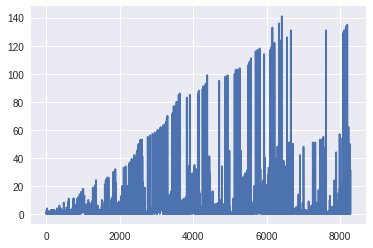

In [48]:
dot_threshold=0.8
response_phrase_cluster=[]
response_phrase_dotproduct_score=np.sum((response_phrase_dotproduct_matrix>dot_threshold),axis=0)
response_phrase_dotproduct_score.shape
plt.plot(response_phrase_dotproduct_score) 
plt.show()


In [102]:
min(response_phrase_distance_vector)

0.0

In [103]:
sentences = ["How are you doing?", "How do you do?"]
encodings=client.encode_texts(sentences)
print(np.linalg.norm(encodings[0]-encodings[1]))
print(np.dot(encodings[0],encodings[1]))
print(encodings.shape)
print(encodings[0][0])

1.1971834460101576
0.2833756958483484
(2, 512)
-0.0467622
